1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти [тут](https://vc.ru/s/productstar/134090-chto-takoe-kogortnyy-analiz).

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти [тут](https://guillaume-martin.github.io/rfm-segmentation-with-python.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import statistics
from collections import Counter
import seaborn as sns
import math
from datetime import datetime
from datetime import timedelta

%matplotlib inline

In [2]:
#подгружаем таблицы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

olist_customers_dataset_url    = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
olist_orders_dataset_url       = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
olist_order_items_dataset_url  = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

In [3]:
olist_customers_dataset_final_url = base_url + urlencode(dict(public_key = olist_customers_dataset_url)) 
response     = requests.get(olist_customers_dataset_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
olist_customers_database = pd.read_csv(download_url) 

In [4]:
olist_customers_database.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [5]:
olist_orders_final_url = base_url + urlencode(dict(public_key = olist_orders_dataset_url)) 
response = requests.get(olist_orders_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
olist_orders_database = pd.read_csv(download_url) 

In [6]:
olist_orders_database.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [7]:
olist_order_items_final_url = base_url + urlencode(dict(public_key = olist_order_items_dataset_url)) 
response = requests.get(olist_order_items_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
olist_order_items_database = pd.read_csv(download_url) 

In [8]:
olist_order_items_database.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [9]:
olist_orders_database.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

### 1) Сколько у нас пользователей, которые совершили покупку только один раз?

In [12]:
olist_orders_database.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [13]:
olist_orders_database.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [14]:
olist_orders_database.shape

(99441, 8)

In [15]:
olist_orders_database.customer_id.nunique()

99441

In [16]:
olist_customers_database.customer_unique_id.nunique()

96096

In [17]:
olist_customers_database.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [18]:
#топ-5 пользователей по количеству действий
olist_customers_database.groupby('customer_unique_id', as_index = False) \
    .agg({'customer_id' : 'count'}) \
    .sort_values('customer_id', ascending = False) \
    .head()

,customer_unique_id,customer_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [19]:
#добавим уникальные id покупателя к таблице с заказами
merged_orders = olist_orders_database.merge(olist_customers_database[['customer_id', 'customer_unique_id']],
                                        on = 'customer_id', how = 'left')

In [20]:
mv_col = merged_orders.pop('customer_unique_id')
merged_orders.insert(2, 'customer_unique_id', mv_col)

In [21]:
merged_orders.head()

,order_id,customer_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [22]:
merged_orders.query('order_status == "canceled"').shape

(625, 9)

In [23]:
merged_orders.query('order_status == "canceled" and not order_delivered_customer_date.isna()').shape

(6, 9)

#### Покупками будем считать все заказы со статусом 'delivered' и с датой доставки товара покупателю ('order_delivered_customer_date')
&emsp; Исходя из этого определения могут возникнуть проблемы с некоторыми пользователями, которые совершили 1 покупку, но в данный момент, например, оформляют 2-ой заказ, для этого будут созданы 2 результирующих датафрейма. В первом будут клиенты, которые совершили 1 покупку и не находятся в процессе покупки/доставки. Во второй таблице будут спорные клиенты.  
&emsp; Не будем учитывать как покупку доставленные, но отмененные заказы. Если есть клиенты, которые совершили 1 покупку и 1+ отказ, то они тоже попадут во 2 таблицу.


In [23]:
#purchases_df = merged_orders.query('order_status == "delivered" and not order_delivered_customer_date.isna()')

In [24]:
merged_orders.query('order_status == "delivered" and order_delivered_customer_date.isna()').shape

(8, 9)

In [25]:
#обозначим статус, когда заказ якобы доставлен, но даты доставки нет
merged_orders.loc[(merged_orders.order_status == 'delivered') 
              & (merged_orders.order_delivered_customer_date.isna()), 'order_status'] = 'broken_status'

In [26]:
merged_orders.query('order_status == "broken_status"')

,order_id,customer_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,13467e882eb3a701826435ee4424f2bd,broken_status,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,2f17c5b324ad603491521b279a9ff4de,broken_status,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN,2018-07-16 00:00:00
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,1bd06a0c0df8b23dacfd3725d2dc0bb9,broken_status,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,3bc508d482a402715be4d5cf4020cc81,broken_status,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,ebf7e0d43a78c81991a4c59c145c75db,broken_status,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaN,2018-07-24 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,d77cf4be2654aa70ef150f8bfec076a6,broken_status,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,cce5e8188bf42ffb3bb5b18ff58f5965,broken_status,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaN,2018-06-26 00:00:00
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,175378436e2978be55b8f4316bce4811,broken_status,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaN,2018-07-19 00:00:00


In [27]:
merged_orders.shape

(99441, 9)

In [28]:
merged_orders.order_id.nunique()

99441

In [29]:
almost_clear_result = merged_orders.groupby(['customer_unique_id', 'order_status'], as_index = False) \
    .agg({'order_id' : 'count'})

In [30]:
almost_clear_result.shape

(96300, 3)

In [31]:
almost_clear_result.head()

,customer_unique_id,order_status,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,delivered,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,delivered,1
2,0000f46a3911fa3c0805444483337064,delivered,1
3,0000f6ccb0745a6a4b88665a16c9f078,delivered,1
4,0004aac84e0df4da2b147fca70cf8255,delivered,1


In [32]:
almost_clear_result.groupby('order_status').agg({'order_id' : 'max'})

,order_id
order_status,
approved,1
broken_status,1
canceled,3
created,1
delivered,15
invoiced,1
processing,1
shipped,2
unavailable,2


In [33]:
almost_clear_pivot = almost_clear_result.pivot(index = 'customer_unique_id', columns = 'order_status', values = 'order_id') \
    .reset_index() \
    .fillna(0)

In [36]:
almost_clear_pivot.head(3)

order_status,customer_unique_id,approved,broken_status,canceled,created,delivered,invoiced,processing,shipped,unavailable
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [37]:
clear_one_purchase_customers = almost_clear_pivot.query('delivered == 1 and \
broken_status + approved + canceled + created + invoiced + processing + shipped + unavailable == 0')

### Итоговая таблица с пользователями, которые совершили 1 покупку и ничего более

In [46]:
clear_one_purchase_customers.head()

order_status,customer_unique_id,approved,broken_status,canceled,created,delivered,invoiced,processing,shipped,unavailable
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [49]:
clear_one_purchase_customers.iloc[:, 1:].sum()

order_status
approved             0.0
broken_status        0.0
canceled             0.0
created              0.0
delivered        90371.0
invoiced             0.0
processing           0.0
shipped              0.0
unavailable          0.0
dtype: float64

In [67]:
almost_clear_result.head()

,customer_unique_id,order_status,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,delivered,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,delivered,1
2,0000f46a3911fa3c0805444483337064,delivered,1
3,0000f6ccb0745a6a4b88665a16c9f078,delivered,1
4,0004aac84e0df4da2b147fca70cf8255,delivered,1


In [75]:
almost_clear_pivot.head()

order_status,customer_unique_id,approved,broken_status,canceled,created,delivered,invoiced,processing,shipped,unavailable
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [68]:
#таблица с клиентами, которые совершили 1 покупку + действие(-я)
moot_customers = almost_clear_pivot.query('delivered == 1')

In [69]:
moot_customers.iloc[:, 1:].sum()

order_status
approved             0.0
broken_status        0.0
canceled            71.0
created              1.0
delivered        90549.0
invoiced            15.0
processing          11.0
shipped             55.0
unavailable         30.0
dtype: float64

In [70]:
almost_clear_pivot.iloc[:, 1:].sum()

order_status
approved             2.0
broken_status        8.0
canceled           625.0
created              5.0
delivered        96470.0
invoiced           314.0
processing         301.0
shipped           1107.0
unavailable        609.0
dtype: float64

### Спорные клиенты

In [186]:
#сделал через мердж, чтобы запомнить, что так можно :)
moot_customers = pd.merge(moot_customers, clear_one_purchase_customers, how = "outer", indicator = True)
moot_customers = moot_customers[moot_customers['_merge'] == 'left_only']

In [187]:
moot_customers = moot_customers.drop('_merge', axis = 1)

In [188]:
moot_customers

order_status,customer_unique_id,approved,broken_status,canceled,created,delivered,invoiced,processing,shipped,unavailable
0,00172711b30d52eea8b313a7f2cced02,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,004b45ec5c64187465168251cd1c9c2f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0058f300f57d7b93c477a131a59b36c3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,018b5a7502c30eb5f230f1b4eb23a156,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,01ea7dfdac01a4e8fbe2902b73510b20,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
173,f8af7fabb3e9e70beee01db243cd3eaa,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
174,f8c74f26f568c1b52cd212e700e977df,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
175,fd0e843308b676214ea30ea480295e3e,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
176,fe28d443ab89dc67f5858bc2beda299a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [189]:
moot_customers.iloc[:, 1:].sum()

order_status
approved           0.0
broken_status      0.0
canceled          71.0
created            1.0
delivered        178.0
invoiced          15.0
processing        11.0
shipped           55.0
unavailable       30.0
dtype: float64

### 2) Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)

In [190]:
merged_orders.head()

,order_id,customer_id,customer_unique_id,order_status,purchase_dayofweek,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,delivered,5,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,delivered,1,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [191]:
reasons_for_non_delivery = merged_orders[['order_status', 'order_estimated_delivery_date']].query('order_status != "delivered"')

In [192]:
reasons_for_non_delivery

,order_status,order_estimated_delivery_date
6,invoiced,2017-05-09 00:00:00
44,shipped,2018-06-28 00:00:00
103,invoiced,2018-08-21 00:00:00
128,processing,2017-10-03 00:00:00
154,shipped,2018-02-07 00:00:00
...,...,...
99283,canceled,2018-10-01 00:00:00
99313,processing,2018-02-06 00:00:00
99347,canceled,2018-09-27 00:00:00
99348,unavailable,2017-09-15 00:00:00


In [193]:
reasons_for_non_delivery.groupby('order_status', as_index = False) \
    .agg({'order_estimated_delivery_date' : 'count'})

,order_status,order_estimated_delivery_date
0,approved,2
1,broken_status,8
2,canceled,625
3,created,5
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [194]:
reasons_for_non_delivery['month'] = reasons_for_non_delivery.order_estimated_delivery_date.astype('datetime64[M]')

In [195]:
reasons_for_non_delivery.head(3)

,order_status,order_estimated_delivery_date,month
6,invoiced,2017-05-09 00:00:00,2017-05-01
44,shipped,2018-06-28 00:00:00,2018-06-01
103,invoiced,2018-08-21 00:00:00,2018-08-01


In [196]:
reasons_for_non_delivery = reasons_for_non_delivery.groupby(['month', 'order_status'], as_index = False) \
    .agg({'order_estimated_delivery_date' : 'count'})

In [197]:
reasons_for_non_delivery.head(3)

,month,order_status,order_estimated_delivery_date
0,2016-09-01,canceled,1
1,2016-10-01,canceled,3
2,2016-10-01,shipped,1


In [198]:
reasons_for_non_delivery_pivot = reasons_for_non_delivery.pivot(index   = 'month',
                                                                columns = 'order_status',
                                                                values  = 'order_estimated_delivery_date') \
                                                                .fillna(0) \
                                                                .reset_index()

In [199]:
reasons_for_non_delivery_pivot.month = pd.to_datetime(reasons_for_non_delivery_pivot.month)

In [200]:
reasons_for_non_delivery_pivot = reasons_for_non_delivery_pivot.sort_values('month')

In [201]:
#итоговая таблица по месяцам
reasons_for_non_delivery_pivot

order_status,month,approved,broken_status,canceled,created,invoiced,processing,shipped,unavailable
0,2016-09-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2016-10-01,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0
2,2016-11-01,0.0,0.0,14.0,0.0,9.0,0.0,1.0,5.0
3,2016-12-01,0.0,0.0,8.0,0.0,9.0,2.0,7.0,2.0
4,2017-02-01,0.0,0.0,2.0,0.0,1.0,1.0,6.0,2.0
5,2017-03-01,1.0,0.0,26.0,0.0,21.0,38.0,41.0,66.0
6,2017-04-01,0.0,0.0,22.0,0.0,5.0,23.0,35.0,19.0
7,2017-05-01,1.0,0.0,23.0,0.0,19.0,12.0,60.0,16.0
8,2017-06-01,0.0,1.0,29.0,0.0,11.0,22.0,52.0,29.0
9,2017-07-01,0.0,0.0,21.0,0.0,10.0,13.0,51.0,34.0


In [88]:
#средние значения по месяцам
reasons_for_non_delivery_pivot.iloc[:, 1:].mean() \
    .sort_values(ascending = False)

order_status
shipped          42.576923
canceled         24.038462
unavailable      23.423077
invoiced         12.076923
processing       11.576923
broken_status     0.307692
created           0.192308
approved          0.076923
dtype: float64

### 3) По каждому товару определить, в какой день недели товар чаще всего покупается


In [89]:
olist_order_items_database.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [90]:
merged_orders.head(3)

,order_id,customer_id,customer_unique_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [91]:
olist_order_items_database.shape

(112650, 7)

In [92]:
merged_orders.shape

(99441, 9)

In [93]:
merged_orders.order_status.value_counts()

delivered        96470
shipped           1107
canceled           625
unavailable        609
invoiced           314
processing         301
broken_status        8
created              5
approved             2
Name: order_status, dtype: int64

### Возьмем только те заказы, в которых мы точно уверены - 'delivered' с датой доставки.

In [95]:
#создал колонку с днем недели где 0 - пн и 6 - вс
merged_orders['purchase_dayofweek'] = pd.to_datetime(merged_orders.order_purchase_timestamp).dt.dayofweek

In [96]:
mv_col = merged_orders.pop('purchase_dayofweek')
merged_orders.insert(4, 'purchase_dayofweek', mv_col)

In [97]:
merged_orders.head(3)

,order_id,customer_id,customer_unique_id,order_status,purchase_dayofweek,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [98]:
order_dayofweek = merged_orders.query('order_status == "delivered"')[['order_id', 'purchase_dayofweek']]

In [101]:
order_dayofweek.head()

,order_id,purchase_dayofweek
0,e481f51cbdc54678b7cc49136f2d6af7,0
1,53cdb2fc8bc7dce0b6741e2150273451,1
2,47770eb9100c2d0c44946d9cf07ec65d,2
3,949d5b44dbf5de918fe9c16f97b45f8a,5
4,ad21c59c0840e6cb83a9ceb5573f8159,1


In [102]:
olist_order_items_database.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [103]:
#таблица с айди заказа и продукта + день недели, когда был куплен товар
merged_dayofweek_orders = pd.merge(olist_order_items_database[['order_id', 'product_id']], order_dayofweek,
                                   on = 'order_id', how = 'inner')

In [104]:
merged_dayofweek_orders.shape

(110189, 3)

In [105]:
merged_dayofweek_orders.head()

,order_id,product_id,purchase_dayofweek
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,2
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,2
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,2
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,5


In [106]:
def multimode(lst):
    res  = [] 
    lst1 = Counter(lst)
    temp = lst1.most_common(1)[0][1]
    for ele in lst:
          if lst.count(ele) == temp:
                res.append(ele)
    return list(set(res))

In [107]:
from platform import python_version
print(python_version())

3.7.3


In [108]:
merged_dayofweek_orders.shape

(110189, 3)

In [109]:
product_mode_dayofweek = merged_dayofweek_orders.groupby('product_id', as_index = False) \
    .agg({'purchase_dayofweek': list})

In [111]:
#таблица с продуктом и списком всех дней, когда его покупали
product_mode_dayofweek.head()

,product_id,purchase_dayofweek
0,00066f42aeeb9f3007548bb9d3f33c38,[6]
1,00088930e925c41fd95ebfe695fd2655,[1]
2,0009406fd7479715e4bef61dd91f2462,[3]
3,000b8f95fcb9e0096488278317764d19,"[4, 2]"
4,000d9be29b5207b54e86aa1b1ac54872,[1]


In [112]:
product_mode_dayofweek.purchase_dayofweek = product_mode_dayofweek.purchase_dayofweek.apply(lambda x: multimode(x))

In [114]:
#датафрейм, в котором хранятся id продуктов и дни, в которые чаще всего продавались эти продукты
product_mode_dayofweek.head()

,product_id,purchase_dayofweek
0,00066f42aeeb9f3007548bb9d3f33c38,[6]
1,00088930e925c41fd95ebfe695fd2655,[1]
2,0009406fd7479715e4bef61dd91f2462,[3]
3,000b8f95fcb9e0096488278317764d19,"[2, 4]"
4,000d9be29b5207b54e86aa1b1ac54872,[1]


### 4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [115]:
merged_orders.head(3)

,order_id,customer_id,customer_unique_id,order_status,purchase_dayofweek,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


Будем брать только delivered как покупки

In [116]:
customer_weekmonth_revenue = merged_orders.query('order_status == "delivered"') \
    [['customer_unique_id', 'order_purchase_timestamp', 'purchase_dayofweek']]

In [117]:
customer_weekmonth_revenue.head(3)

,customer_unique_id,order_purchase_timestamp,purchase_dayofweek
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,0
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,1
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2


In [118]:
customer_weekmonth_revenue.order_purchase_timestamp = pd.to_datetime(customer_weekmonth_revenue.order_purchase_timestamp)

In [119]:
customer_weekmonth_revenue['year'] = pd.to_datetime(customer_weekmonth_revenue.order_purchase_timestamp) \
    .dt.year
customer_weekmonth_revenue['month'] = pd.to_datetime(customer_weekmonth_revenue.order_purchase_timestamp) \
    .dt.month
customer_weekmonth_revenue['day_of_month'] = pd.to_datetime(customer_weekmonth_revenue.order_purchase_timestamp) \
    .dt.day

In [120]:
customer_weekmonth_revenue['week_num'] = pd.to_datetime(customer_weekmonth_revenue.order_purchase_timestamp) \
    .dt.isocalendar().week

In [121]:
customer_weekmonth_revenue.head()

,customer_unique_id,order_purchase_timestamp,purchase_dayofweek,year,month,day_of_month,week_num
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,0,2017,10,2,40
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,1,2018,7,24,30
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2,2018,8,8,32
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,5,2017,11,18,46
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,1,2018,2,13,7


In [124]:
#колонка с датой последнего дня недели для каждой недели
customer_weekmonth_revenue['sunday'] = pd.to_datetime(customer_weekmonth_revenue.week_num.astype(str) \
    + customer_weekmonth_revenue.year.astype(str).add('-7'), format = '%V%G-%u')

In [125]:
customer_weekmonth_revenue.head(3)

,customer_unique_id,order_purchase_timestamp,purchase_dayofweek,year,month,day_of_month,week_num,sunday
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,0,2017,10,2,40,2017-10-08
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,1,2018,7,24,30,2018-07-29
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2,2018,8,8,32,2018-08-12


In [126]:
test_df = customer_weekmonth_revenue.copy()

In [127]:
test_df.head(3)

,customer_unique_id,order_purchase_timestamp,purchase_dayofweek,year,month,day_of_month,week_num,sunday
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,0,2017,10,2,40,2017-10-08
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,1,2018,7,24,30,2018-07-29
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2,2018,8,8,32,2018-08-12


In [128]:
# если ВС относится к следующему месяцу то вся неделя идет в следующий месяц
test_df.year = test_df.sunday.dt.year
test_df.month = test_df.sunday.dt.month

In [129]:
test_df.head(3)

,customer_unique_id,order_purchase_timestamp,purchase_dayofweek,year,month,day_of_month,week_num,sunday
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,0,2017,10,2,40,2017-10-08
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,1,2018,7,24,30,2018-07-29
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2,2018,8,8,32,2018-08-12


In [130]:
test_df = test_df.groupby(['customer_unique_id', 'year', 'month', 'week_num'], as_index = False) \
    .agg({'order_purchase_timestamp' : 'count'}) \
    .rename(columns = {'order_purchase_timestamp' : 'purchases_in_week'})

In [134]:
test_df.cnt = test_df.purchases_in_week / 7

In [135]:
test_df.head()

,customer_unique_id,year,month,week_num,purchases_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,19,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,19,1
2,0000f46a3911fa3c0805444483337064,2017,3,10,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,41,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,46,1


In [136]:
test_df.purchases_in_week.mean()

1.0104956634683873

В среднем все наши пользователи если и покупают что-то, то только раз в неделю. Но нужно еще учитывать, что почти все наши пользователи за все время совершили по 1 покупке/действию.

In [137]:
merged_orders.customer_unique_id.value_counts().mean()

1.0348089410589412

### 5) Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [138]:
merged_orders.head(3)

,order_id,customer_id,customer_unique_id,order_status,purchase_dayofweek,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,delivered,0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,delivered,1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [139]:
#сумма по каждому заказу
revenue = olist_order_items_database.groupby('order_id', as_index = False) \
    .agg({'price' : 'sum'})

In [140]:
df = merged_orders[['customer_unique_id', 'order_status', 'order_purchase_timestamp','order_id']]

In [141]:
df = df.query('order_status == "delivered"')

In [142]:
#добавим сумму к заказам
df = pd.merge(df, revenue, on = 'order_id', how = 'inner')

In [143]:
df.head()

,customer_unique_id,order_status,order_purchase_timestamp,order_id,price
0,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,29.99
1,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,159.90
3,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,19.90


Теперь начинается подготовка к построению retention таблицы

In [144]:
first_purchase = df.groupby('customer_unique_id', as_index = False) \
    .agg({'order_purchase_timestamp' : 'min'}) \
    .rename(columns = {'order_purchase_timestamp' : 'first_purchase'})

In [145]:
first_purchase.first_purchase = pd.to_datetime(first_purchase.first_purchase)

In [146]:
first_purchase['first_month'] = first_purchase.first_purchase.astype('datetime64[M]')

In [147]:
first_purchase.first_purchase = first_purchase.first_purchase.dt.date

In [149]:
# получили таблицу с 1 месяцем когда пользователь совершил покупку
# это и будут наши когорты 
first_purchase.head()

,customer_unique_id,first_purchase,first_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-01
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-01
2,0000f46a3911fa3c0805444483337064,2017-03-10,2017-03-01
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,2017-10-01
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,2017-11-01


In [150]:
#соединил таблицы и добавил к основной табличке дату первой покупки пользователя
merged_df = pd.merge(df, first_purchase, on = 'customer_unique_id', how = 'left')

In [151]:
#взял рейндж покупок
min_date = merged_df.first_month.min()
max_date = merged_df.first_month.max()

In [152]:
min_date

Timestamp('2016-09-01 00:00:00')

In [153]:
max_date

Timestamp('2018-08-01 00:00:00')

In [154]:
#задал этот рейндж в виде таблицы
month = pd.DataFrame(pd.date_range(min_date, max_date, freq = 'MS'))

In [155]:
month.columns = ['month']

In [156]:
merged_df['key'] = 1
month['key'] = 1

In [157]:
month.columns

Index(['month', 'key'], dtype='object')

In [158]:
#на каждого пользователя накинем все месяцы
template = merged_df.merge(month, on = 'key')[['customer_unique_id', 'order_id', 'first_month', 'month']]

In [159]:
template.head()

,customer_unique_id,order_id,first_month,month
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2016-09-01
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2016-10-01
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2016-11-01
3,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2016-12-01
4,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-01-01


In [160]:
#лишние значения
template = template.query('month >= first_month')

In [162]:
template.head()

,customer_unique_id,order_id,first_month,month
12,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-09-01
13,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-10-01
14,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-11-01
15,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-12-01
16,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2018-01-01


In [163]:
merged_df = merged_df.drop(columns = ['key'])

In [164]:
#добавим столбец с месяцем покупки
merged_df['transaction_month'] = merged_df.order_purchase_timestamp.astype('datetime64[M]')

In [166]:
merged_df.head()

,customer_unique_id,order_status,order_purchase_timestamp,order_id,price,first_purchase,first_month,transaction_month
0,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,29.99,2017-09-04,2017-09-01,2017-10-01
1,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,118.70,2018-07-24,2018-07-01,2018-07-01
2,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,159.90,2018-08-08,2018-08-01,2018-08-01
3,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,45.00,2017-11-18,2017-11-01,2017-11-01
4,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,19.90,2018-02-13,2018-02-01,2018-02-01


In [167]:
trans_month = pd.DataFrame(merged_df.groupby(['customer_unique_id', 'transaction_month'])['price'].sum()) \
    .reset_index()

In [168]:
trans_month = trans_month.rename(columns={'transaction_month': 'month'})

In [170]:
#таблица с суммой по каждому месяцу
trans_month.head()

,customer_unique_id,month,price
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,18.90
2,0000f46a3911fa3c0805444483337064,2017-03-01,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,25.99
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,180.00


In [171]:
# Таблица в которой по каждому пользователю показаны покупки за все время от первой покупки до последнего месяца
report = template.merge(trans_month, on = ['customer_unique_id','month'], how = 'left')

In [172]:
report.head()

,customer_unique_id,order_id,first_month,month,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-09-01,35.39
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-10-01,29.99
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-11-01,NaN
3,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-12-01,NaN
4,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2018-01-01,NaN


In [173]:
report['active'] = (report.price > 0) * 1

In [174]:
report.head()

,customer_unique_id,order_id,first_month,month,price,active
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-09-01,35.39,1
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-10-01,29.99,1
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-11-01,NaN,0
3,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2017-12-01,NaN,0
4,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-09-01,2018-01-01,NaN,0


In [175]:
# Итоговая таблица retention
retention = report.pivot_table(index = 'first_month', columns = 'month', values = 'active', aggfunc = 'mean')

In [176]:
retention.head()

month,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,...,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01
first_month,,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10-01,NaN,1.0,0.0,0.0,0.0,0.000000,0.000000,0.007273,0.000000,0.000000,...,0.007273,0.000000,0.007273,0.000000,0.007273,0.000000,0.014545,0.018182,0.000000,0.000000
2016-12-01,NaN,NaN,NaN,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-01,NaN,NaN,NaN,NaN,1.0,0.006386,0.005109,0.002554,0.010217,0.002554,...,0.010217,0.002554,0.014049,0.007663,0.003831,0.002554,0.005109,0.007663,0.000000,0.002554
2017-02-01,NaN,NaN,NaN,NaN,NaN,1.000000,0.003527,0.005879,0.002939,0.008230,...,0.004115,0.002939,0.006467,0.002352,0.004115,0.002352,0.001176,0.001176,0.004115,0.000000


In [177]:
#откинем все что дальше нужного года
retention = retention.reset_index().iloc[:,:17].set_index('first_month')

In [178]:
retention.head()

month,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00,2016-12-01 00:00:00,2017-01-01 00:00:00,2017-02-01 00:00:00,2017-03-01 00:00:00,2017-04-01 00:00:00,2017-05-01 00:00:00,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00
first_month,,,,,,,,,,,,,,,,
2016-09-01,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10-01,NaN,1.0,0.0,0.0,0.0,0.000000,0.000000,0.007273,0.000000,0.000000,0.007273,0.000000,0.010909,0.000000,0.007273,0.000000
2016-12-01,NaN,NaN,NaN,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-01,NaN,NaN,NaN,NaN,1.0,0.006386,0.005109,0.002554,0.010217,0.002554,0.007663,0.003831,0.003831,0.000000,0.010217,0.002554
2017-02-01,NaN,NaN,NaN,NaN,NaN,1.000000,0.003527,0.005879,0.002939,0.008230,0.002352,0.005291,0.004115,0.002352,0.004115,0.002939


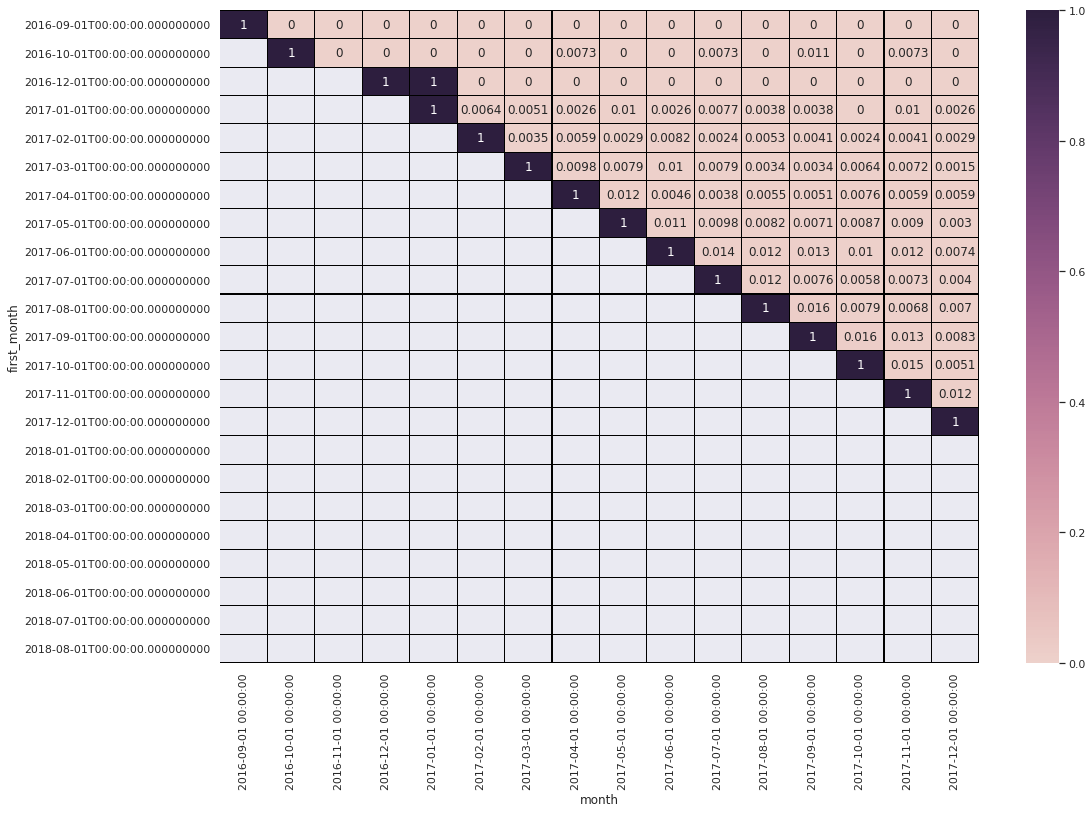

In [179]:
sns.set(font_scale = 1, rc = {'figure.figsize' : (17,12)})
sns.heatmap(retention, cmap = sns.cubehelix_palette(as_cmap = True),
            annot = True, linecolor = 'black', linewidths = 0.1)

In [180]:
#Таблица с лайфтаймом и retention по когортам
third_month_report = report.copy()

In [181]:
third_month_report['lifetime'] = ((report['month'] - report['first_month']) / np.timedelta64(1, 'M')).round().astype(int)

In [182]:
third_month_report = third_month_report.groupby(['first_month', 'lifetime'], as_index = False) \
    .agg({'active' : 'mean'}) \
    .query('lifetime == 2')

In [183]:
max_third_month_retention = third_month_report.active.max()

In [1]:
#на графике плохо видно какая когорта нам нужна
#посмотрим на топ retention с лайфтаймом 2 (3 месяц) запросом
third_month_report.query('active == @max_third_month_retention')

NameError: name 'third_month_report' is not defined

**6) Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию**

In [10]:
customers = olist_customers_database
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [11]:
orders = olist_orders_database
orders[orders.columns[3:8]] = orders[orders.columns[3:8]].apply(pd.to_datetime, errors='coerce')

In [12]:
order_items = olist_order_items_database

In [13]:
rfm_df = customers.copy().merge(orders, on = 'customer_id').merge(order_items, on = 'order_id')
rfm_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
112646,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
112647,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
112648,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [14]:
#у нас есть данные за 2 года
print('Orders from {} to {}, {} in total'.format(rfm_df['order_purchase_timestamp'].min(),
                                    rfm_df['order_purchase_timestamp'].max(),
                                    (rfm_df['order_purchase_timestamp'].max() \
                                        - rfm_df['order_purchase_timestamp'].min())))

Orders from 2016-09-04 21:15:19 to 2018-09-03 09:06:57, 728 days 11:51:38 in total


In [15]:
#определим период RFM анализа в один год
period = 365

In [16]:
now = rfm_df['order_purchase_timestamp'].max() + timedelta(days=1)
now

Timestamp('2018-09-04 09:06:57')

In [17]:
#Определим разницу между датой первого заказа и текущей датой (now)
rfm_df['DaysSinceOrder'] = rfm_df['order_purchase_timestamp'].apply(lambda x: (now - x).days)

In [18]:
#Recency score - время от последней покупки пользователя до текущей даты

In [19]:
#Определим recency score для каждого клиента и запишем в отдельный датафрейм
rfm = 0
rfm = rfm_df.groupby('customer_unique_id').agg({'DaysSinceOrder': lambda x: x.min()}).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency'}, inplace=True)
rfm = rfm.query('Recency <= @ period')
rfm.head()

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293
5,0004bd2a26a76fe21f786e4fbd80607f,151


In [20]:
#Frequency score - суммарное количество покупок у пользователя за рассматриваемый период

In [21]:
period_td = now - timedelta(days = period)

In [22]:
rfm = rfm_df \
            .query('(order_approved_at.isna() == False) \
                          & (order_purchase_timestamp >= @period_td)') \
            .groupby('customer_unique_id',as_index = False) \
            .agg({'order_id': 'nunique'}) \
            .rename(columns = {'order_id': 'Frequency'}) \
            .merge(rfm, on = 'customer_unique_id') \
            .sort_values('Frequency', ascending = False)

In [23]:
rfm = rfm[['customer_unique_id','Recency','Frequency']]
rfm.head()

,customer_unique_id,Recency,Frequency
40299,8d50f5eadf50201ccdcedfb9e2ac8455,14,11
17839,3e43e6105506432c953e165fb2acf44c,188,9
28722,6469f99c1f9dfae7733b25662e7f1782,68,7
7811,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7
57997,ca77025e7201e3b30c44b472ff346268,94,7


In [24]:
#Monetary score - сумма покупок за рассматриваемый период

In [25]:
rfm = rfm_df \
            .query('(order_approved_at.isna() == False) \
                          & (order_purchase_timestamp >= @period_td)') \
            .groupby('customer_unique_id',as_index = False) \
            .agg({'price': 'sum'}) \
            .rename(columns = {'price': 'Monetary'}) \
            .merge(rfm, on = 'customer_unique_id') \
            .sort_values('Frequency', ascending = False)

In [26]:
rfm = rfm[['customer_unique_id','Recency','Frequency','Monetary']]
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
40299,8d50f5eadf50201ccdcedfb9e2ac8455,14,11,440.94
17839,3e43e6105506432c953e165fb2acf44c,188,9,1000.85
28722,6469f99c1f9dfae7733b25662e7f1782,68,7,664.20
7811,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,809.21
57997,ca77025e7201e3b30c44b472ff346268,94,7,806.61


In [27]:
#Расчет RFM Scores и ранжирование

In [28]:
#Границы ранжирования
quantiles = rfm[['Recency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quantiles

{'Recency': {0.2: 75.0, 0.4: 143.0, 0.6: 207.0, 0.8: 279.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.8}}

In [29]:
rfm[['Frequency']].value_counts().reset_index().sort_values('Frequency',ascending = False)

,Frequency,0
6,11,1
7,9,1
5,7,3
4,5,5
3,4,16
2,3,98
1,2,1721
0,1,71402


In [30]:
#функции для ранжирования от 1 до 5, где 1 - наилучший показатель, 5 - наихудший
def r_score(x):
    if x <= quantiles['Recency'][0.2]:
        return 1
    elif x <= quantiles['Recency'][0.4]:
        return 2
    elif x <= quantiles['Recency'][0.6]:
        return 3
    elif x <= quantiles['Recency'][0.8]:
        return 4
    else:
        return 5
    
def f_score(x):
    if x >= 5:   # Количество заказов больше 5
        return 1
    elif x >= 4: # Количество заказов больше 4
        return 2
    elif x >= 3: # Количество заказов больше 3
        return 3 
    elif x >= 2: # Количество заказов больше 2
        return 4 
    else:
        return 5        

def m_score(x):
    if x <= quantiles['Monetary'][0.2]:
        return 1
    elif x <= quantiles['Monetary'][0.4]:
        return 2
    elif x <= quantiles['Monetary'][0.6]:
        return 3
    elif x <= quantiles['Monetary'][0.8]:
        return 4
    else:
        return 5  

In [31]:
#Проранжируем пользователей по каждому из критериев
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))
rfm

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
40299,8d50f5eadf50201ccdcedfb9e2ac8455,14,11,440.94,1,1,5
17839,3e43e6105506432c953e165fb2acf44c,188,9,1000.85,3,1,5
28722,6469f99c1f9dfae7733b25662e7f1782,68,7,664.20,1,1,5
7811,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,809.21,3,1,5
57997,ca77025e7201e3b30c44b472ff346268,94,7,806.61,2,1,5
...,...,...,...,...,...,...,...
24718,568c55c1df1dd77d62d3c93f7d03c58b,21,1,100.00,1,5,3
24719,568eaa9cb9e6f86c86437263c0d5ed4a,160,1,27.90,3,5,1
24720,568fe2ba86695cfdba6ab2f56d8c5dde,349,1,299.99,5,5,5
24721,5690fe2160726cc9d85921d03beefb25,17,1,201.00,1,5,5


In [32]:
#Oбщий rfm score
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
40299,8d50f5eadf50201ccdcedfb9e2ac8455,14,11,440.94,1,1,5,115
17839,3e43e6105506432c953e165fb2acf44c,188,9,1000.85,3,1,5,315
28722,6469f99c1f9dfae7733b25662e7f1782,68,7,664.20,1,1,5,115
7811,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,809.21,3,1,5,315
57997,ca77025e7201e3b30c44b472ff346268,94,7,806.61,2,1,5,215


In [33]:
rfm.RFM_Score.nunique()

75

In [34]:
#Датафрейм с информацией о квантилях, соответствующих им значениям Recency, Frequency, Monetary и присвоенном ранге
ranking = pd.DataFrame(quantiles).reset_index().rename(columns = {'index':'Quantiles_M'})
ranking ['Frequency'] = rfm[['Frequency']].value_counts().head(5).sort_values(ascending = False).reset_index().iloc[::-1].Frequency.shift(1)
ranking ['Recency'] = ranking['Recency'][::-1].reset_index(drop = True)
ranking ['Quantiles_R'] = ranking['Quantiles_M'][::-1].reset_index(drop = True)
ranking ['Rank'] = [4,3,2,1]
ranking = ranking[['Rank','Quantiles_R','Recency', 'Frequency', 'Monetary','Quantiles_M']].sort_values('Rank').reset_index(drop = True)

In [35]:
ranking

,Rank,Quantiles_R,Recency,Frequency,Monetary,Quantiles_M
0,1,0.2,75.0,5.0,179.80,0.8
1,2,0.4,143.0,4.0,109.99,0.6
2,3,0.6,207.0,3.0,69.90,0.4
3,4,0.8,279.0,2.0,39.90,0.2


In [36]:
#Функции, определяющие границы сегмента для каждой из метрик

In [37]:
#Границы по Recency
def bounds_r (RFM_score):
    if RFM_score[0] == '1':
        return ('Recency  > ' + str(ranking[ranking['Rank'] == 1 ].Recency.item()) )
    elif RFM_score[0] == '2':
        return (str(ranking[ranking['Rank'] == 1 ].Recency.item()) 
              + ' >= Recency > ' 
              + str(ranking[ranking['Rank'] == 2 ].Recency.item()))
    elif RFM_score[0] == '3':
        return (str(ranking[ranking['Rank'] == 2 ].Recency.item()) 
              + ' >= Recency > ' 
              + str(ranking[ranking['Rank'] == 3 ].Recency.item()))
    elif RFM_score[0] == '4':
        return (str(ranking[ranking['Rank'] == 3 ].Recency.item()) 
              + ' >= Recency > ' 
              + str(ranking[ranking['Rank'] == 4 ].Recency.item()))
    else: 
        return (str(ranking[ranking['Rank'] == 4 ].Recency.item()) 
              + ' >= Recency')

In [38]:
#Границы по Frequency
def bounds_f (RFM_score):
    if RFM_score[1] == '1':
        return ('Frequency  > ' + str(ranking[ranking['Rank'] == 1 ].Frequency.item()) )
    elif RFM_score[1] == '2':
        return (str(ranking[ranking['Rank'] == 1 ].Frequency.item()) 
              + ' > Frequency >= ' 
              + str(ranking[ranking['Rank'] == 2 ].Frequency.item()) )
    elif RFM_score[1] == '3':
        return (str(ranking[ranking['Rank'] == 2 ].Frequency.item()) 
              + ' > Frequency >= ' 
              + str(ranking[ranking['Rank'] == 3 ].Frequency.item()) )
    elif RFM_score[1] == '4':
        return (str(ranking[ranking['Rank'] == 3 ].Frequency.item()) 
              + ' > Frequency >= ' 
              + str(ranking[ranking['Rank'] == 4 ].Frequency.item()) )
    else: 
        return (str(ranking[ranking['Rank'] == 4 ].Frequency.item()) 
              + ' > Frequency')

In [39]:
#Границы по Monetary
def bounds_m (RFM_score):
    if RFM_score[2] == '1':
        return ('Monetary  >= ' + str(ranking[ranking['Rank'] == 1 ].Monetary.item()) )
    elif RFM_score[2] == '2':
        return (str(ranking[ranking['Rank'] == 1 ].Monetary.item()) 
              + ' >= Monetary > ' 
              + str(ranking[ranking['Rank'] == 2 ].Monetary.item()) )
    elif RFM_score[2] == '3':
        return (str(ranking[ranking['Rank'] == 2 ].Monetary.item()) 
              + ' >= Monetary > ' 
              + str(ranking[ranking['Rank'] == 3 ].Monetary.item()) )
    elif RFM_score[2] == '4':
        return (str(ranking[ranking['Rank'] == 3 ].Monetary.item()) 
              + ' >= Monetary > ' 
              + str(ranking[ranking['Rank'] == 4 ].Monetary.item()) )
    else: 
        return (str(ranking[ranking['Rank'] == 4 ].Monetary.item()) 
              + ' >= Monetary')

In [40]:
#Добавим в датафрейм информацию о границах для каждой метрики
rfm['R_boundaries'] = rfm.RFM_Score.apply(lambda x: bounds_r(x))
rfm['F_boundaries'] = rfm.RFM_Score.apply(lambda x: bounds_f(x))
rfm['M_boundaries'] = rfm.RFM_Score.apply(lambda x: bounds_m(x))
rfm

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,R_boundaries,F_boundaries,M_boundaries
40299,8d50f5eadf50201ccdcedfb9e2ac8455,14,11,440.94,1,1,5,115,Recency > 75.0,Frequency > 5.0,39.9 >= Monetary
17839,3e43e6105506432c953e165fb2acf44c,188,9,1000.85,3,1,5,315,143.0 >= Recency > 207.0,Frequency > 5.0,39.9 >= Monetary
28722,6469f99c1f9dfae7733b25662e7f1782,68,7,664.20,1,1,5,115,Recency > 75.0,Frequency > 5.0,39.9 >= Monetary
7811,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,809.21,3,1,5,315,143.0 >= Recency > 207.0,Frequency > 5.0,39.9 >= Monetary
57997,ca77025e7201e3b30c44b472ff346268,94,7,806.61,2,1,5,215,75.0 >= Recency > 143.0,Frequency > 5.0,39.9 >= Monetary
...,...,...,...,...,...,...,...,...,...,...,...
24718,568c55c1df1dd77d62d3c93f7d03c58b,21,1,100.00,1,5,3,153,Recency > 75.0,2.0 > Frequency,109.99 >= Monetary > 69.9
24719,568eaa9cb9e6f86c86437263c0d5ed4a,160,1,27.90,3,5,1,351,143.0 >= Recency > 207.0,2.0 > Frequency,Monetary >= 179.8
24720,568fe2ba86695cfdba6ab2f56d8c5dde,349,1,299.99,5,5,5,555,279.0 >= Recency,2.0 > Frequency,39.9 >= Monetary
24721,5690fe2160726cc9d85921d03beefb25,17,1,201.00,1,5,5,155,Recency > 75.0,2.0 > Frequency,39.9 >= Monetary


Сегментация

In [43]:
segt_map = {
    r'[1-2][1-2]': 'champions',
    r'[3-4][1-2]': 'loyal customers',
    r'[1-2][2-3]': 'potential loyalists',
    r'1[4-5]': 'new customers',
    r'2[4-5]': 'promising',
    r'33': 'need attention',
    r'3[4-5]': 'about to sleep',
    r'[3-4][1-2]': 'at risk',
    r'5[1-2]': 'can\'t loose',
    r'[4-5][3-5]': 'hibernating'
}

**Описание Сегментов**

Champions [R = 1-2, FM = 1-2] - Совершили первую покупку недавно, покупают часто и тратят много. Необходимо поддерживать заданный уровень сервиса для данного сегмента.

Loyal Customers [R = 3-4 , FM = 1-2] - Совершили первую покупку давно, покупают часто и тратят много. Необходимо поддерживать заданный уровень сервиса для данного сегмента.

Potential Loyalist [R = 1-2, FM = 2-3] - Совершили первую покупку недавно, покупают нечасто. Важно активно вовлекать сегмент в дальнейшее взаимодействие с продуктом.

New Customers [R = 1, FM = 4-5] - Совершили первую покупку недавно, но не успели купить много. Важно активно вовлекать сегмент в дальнейшее взаимодействие с продуктом.

Promising [R = 2, FM = 4-5] - Совершили первую покупку чуть раньше New Customers, но все еще не успели купить много. Важно активно вовлекать сегмент в дальнейшее взаимодействие с продуктом.

Need Attention [R = 3 , FM = 3] - "Середнячки" по активности. Основная фокусная группа, т.к. наиболее подвержена переходу как в более активные группы, так и менее активные.

About To Sleep [R = 3, FM = 4-5] - Покупали недавно, но в ограниченных количествах. Вероятно на этапе знакомства с продуктом их что-то не устроило.

At Risk [R = 3-4, FM = 1-2] - Покупали часто, но относительно давно. Имеют высокий риск перехода в менее активные сегменты

Can’t Lose [R = 5, FM = 1-2] - Покупали часто, но давно. Вероятно готовы отказаться от продукта. Имеет смысл стараться вернуть этих клиентов через индивидуальные промо-кампании.

Hibernating [R = 4-5, FM = 3-5] - Последняя покупка была совершена давно. Средний чек и частота покупок минимальны. Вероятнее всего продукт не устроил с самого начала.

Примечание: Активность - частота и recency

In [44]:
segt_map

{'[1-2][1-2]': 'champions',
 '[3-4][1-2]': 'at risk',
 '[1-2][2-3]': 'potential loyalists',
 '1[4-5]': 'new customers',
 '2[4-5]': 'promising',
 '33': 'need attention',
 '3[4-5]': 'about to sleep',
 '5[1-2]': "can't loose",
 '[4-5][3-5]': 'hibernating'}

In [45]:
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,R_boundaries,F_boundaries,M_boundaries,Segment
40299,8d50f5eadf50201ccdcedfb9e2ac8455,14,11,440.94,1,1,5,115,Recency > 75.0,Frequency > 5.0,39.9 >= Monetary,champions
17839,3e43e6105506432c953e165fb2acf44c,188,9,1000.85,3,1,5,315,143.0 >= Recency > 207.0,Frequency > 5.0,39.9 >= Monetary,at risk
28722,6469f99c1f9dfae7733b25662e7f1782,68,7,664.20,1,1,5,115,Recency > 75.0,Frequency > 5.0,39.9 >= Monetary,champions
7811,1b6c7548a2a1f9037c1fd3ddfed95f33,201,7,809.21,3,1,5,315,143.0 >= Recency > 207.0,Frequency > 5.0,39.9 >= Monetary,at risk
57997,ca77025e7201e3b30c44b472ff346268,94,7,806.61,2,1,5,215,75.0 >= Recency > 143.0,Frequency > 5.0,39.9 >= Monetary,champions
...,...,...,...,...,...,...,...,...,...,...,...,...
24718,568c55c1df1dd77d62d3c93f7d03c58b,21,1,100.00,1,5,3,153,Recency > 75.0,2.0 > Frequency,109.99 >= Monetary > 69.9,new customers
24719,568eaa9cb9e6f86c86437263c0d5ed4a,160,1,27.90,3,5,1,351,143.0 >= Recency > 207.0,2.0 > Frequency,Monetary >= 179.8,about to sleep
24720,568fe2ba86695cfdba6ab2f56d8c5dde,349,1,299.99,5,5,5,555,279.0 >= Recency,2.0 > Frequency,39.9 >= Monetary,hibernating
24721,5690fe2160726cc9d85921d03beefb25,17,1,201.00,1,5,5,155,Recency > 75.0,2.0 > Frequency,39.9 >= Monetary,new customers


In [46]:
rfm.Segment.value_counts()

hibernating            29251
new customers          14714
promising              14635
about to sleep         14540
potential loyalists       60
need attention            21
champions                 15
at risk                    9
can't loose                2
Name: Segment, dtype: int64

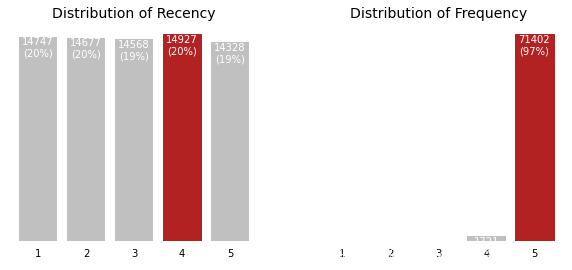

In [48]:
#Построим распределение клиентов по Recency и Frequency
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Видно, что по Recency все клиенты распределены равномерно, что говорит о стабильной работе каналов привлечения.

При этом, частота покупок у 97% клиентов находится на крайне низком уровне: менее 2х покупок

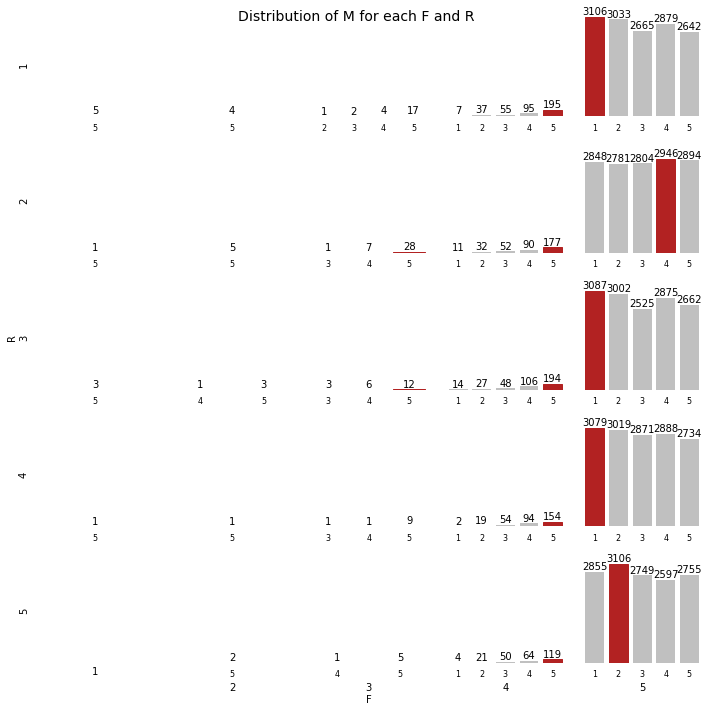

In [50]:
#Построим распределение клиентов по Monetary для каждого ранга Recency и Frequenct
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

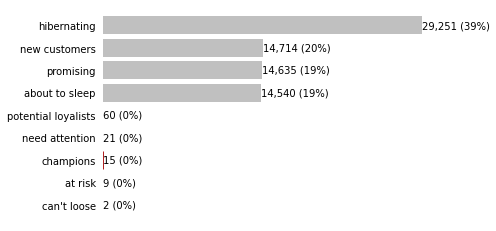

In [51]:
#Определим количество клиентов в каждом из выделенных сегментов
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Как мы видим, 39% всех клиентов попадают в сегмент "Hibernating", который говорит о том, что клиенты совершали покупки давно и в ограниченном количестве. Вероятность возврата таких клиентов в продукт стремится к нулю.

При этом 20% клиентов составляют новые клиенты, которые только знакомятся с продуктом и на которых необходимо делать основной фокус для их дальнейшего перехода в более активные сегменты

Еще 19% занимают клиенты из сегмента promising, которые также, как и клиенты из сегмента New customers только знакомятся с продуктом и не совершают большого количества покупок

Еще 19% составляет сегмент about to sleep, в который входят клиенты, совершавшие покупки достаточно давно, но в ограниченных количествах. У них пониженные ожидания к продукту, однако их все еще можно вовлечь активными кампаниями.

Менее 1% составляют сегменты, генерирующие основную выручку для продукта: potential lialists, need attention, champions, at risk, can`t loose. Это намекает на весомые проблемы в продукте

**Выводы:**

Результаты RFM анализа говорят о 2 ключевых фактах:

В продукте высокая эффективность каналов привлечения. В продукт активно и регулярно приходят новые пользователи и начинают знакомство с ним.
Сам продукт не удовлетворяет ожиданиям новых пользователей после знакомства с ним. 39% клиентов не решают продолжать пользоваться продуктом после знакомства с ним. Это может говорить о 2х проблемах: 1) В продукт приходят нерелевантные пользователи из каналов привлечения. 2) В продукте есть системные проблемы, значительно усложняющие клиентский путь.
Таким образом, рекомендуется:

1. Сравнить портрет клиента в продукте с портретом клиента в каналах привлечения для определения расхождений. 
2. В случае отсутствия расхождения в путке 1, детально посмотреть на клиентский путь пользователя через призму конверсии/ интервью и определить ключевые проблемы клиентов
​
